In [1]:
import numpy as np
import networkx as nx
import os
import typing

import torch
from torch.nn import Linear 

from torch.nn.modules.module import Module
import torch.nn.functional as F

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
dataset_folder = "cora/"

In [3]:
[x for x in os.walk(dataset_folder)]

[('cora/', [], ['README', 'cora.content', 'cora.cites'])]

# DATA

In [4]:

file_cities = os.path.join(dataset_folder,'cora.cites')
file_content = os.path.join(dataset_folder,'cora.content')

In [5]:
def get_edges(file_cities: str) -> np.array:
    
    """ Method return all edges array"""
    
    edges = []
    with open(file=file_cities,mode='r') as f:
        for data in f.readlines():
            data = data.split('\t')
            edges.append((data[0],data[1][:-1]))
            
    return np.asarray(edges)


def get_node_info(file_content: str ) -> np.array:
    
    """Method return node name and index, nodes features and lables"""
    
    nodes_index ={}
    nodes_features = []
    labels = []

    with open(file=file_content,mode='r') as f:
        for i,data in enumerate(f.readlines()):
            data = data.split('\t')
            nodes_index[data[0]]= i 
            nodes_features.append(data[1:-1])
            labels.append(data[-1][:-1])
    
    return nodes_index,np.asarray(nodes_features,dtype = int),np.asarray(labels)


def label_encode(lables: typing.List) ->typing.Tuple:
    
    """ Method for lable encode"""
    
    le = preprocessing.LabelEncoder()
    lables = le.fit_transform(lables)
    
    return le.classes_,lables


def get_graph(edges: typing.List[typing.Set]):
    """ Method to get Graph"""
    
    G = nx.Graph()
    #G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    print('Graph info: ', nx.info(G))
    
    return G
    

In [6]:
edges = get_edges(file_cities)
nodes_index,nodes_features,labels = get_node_info(file_content)
G =get_graph(edges=edges)
label_class, labels=label_encode(labels)


print("Sample edge",edges[0])
total_no_of_nodes = len(nodes_features)
print("vocabulary of size {} unique words".format(len(nodes_features[0])))
print("Number of nodes",total_no_of_nodes)
total_no_of_class = len(set(labels))
print("Number of class",total_no_of_class)
print("class label :", label_class)

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981
Sample edge ['35' '1033']
vocabulary of size 1433 unique words
Number of nodes 2708
Number of class 7
class label : ['Case_Based' 'Genetic_Algorithms' 'Neural_Networks'
 'Probabilistic_Methods' 'Reinforcement_Learning' 'Rule_Learning' 'Theory']


In [7]:

# get matrix and nodes
adj_matrix, nodes = nx.attr_matrix(G)
adj_matrix, nodes = np.asarray(adj_matrix), np.asarray(nodes, dtype=int)

# degree for each node
degree = dict(G.degree())

# add self loop
np.fill_diagonal(adj_matrix, 1)

# nodes fearures in order with adj_matrix nodes
nodes_features = np.array([nodes_features[nodes_index[str(node)]] for node in nodes])

# create dignal matrix
degree_matrix = np.diag([ degree[str(node)] for node in nodes])

# inververt matrix
deg = np.linalg.inv(degree_matrix)

# order lable by nodes
labels = [labels[nodes_index[str(node)]]  for node in nodes]

In [8]:
device=torch.device('cpu')

# if gpu available replace device
if torch.cuda.is_available():
    device=torch.device('cuda')



In [9]:

class GCN(Module):
    """ graph convolutional network"""
    
    def __init__(self, in_features: int,
                 out_features: int) -> None:
        
        super(GCN, self).__init__()
        self.lin = Linear(in_features, out_features)
    
    
    def forward(self,adj_matrix:  torch.Tensor,
                nodes_features: torch.Tensor,
                deg: torch.Tensor) -> torch.Tensor:
    
        # message passing
        # normalization
        nodes_features = deg.mm(adj_matrix.mm(deg.mm(nodes_features)))
        # linear traonfomation AX^T + B
        nodes_features = self.lin(nodes_features)
        
        return nodes_features
        
    

In [10]:
class Model(Module):
    
    def __init__(self,num_node_features : int,
                 num_classes : int, 
                 hidden_nodes = 16)-> None: 
        
        """ num_node_features: input feature size
            num_classes: no of class
            hidden_nodes: hidden unit
        """
        super(Model,self).__init__()
        
        self.gcn1 = GCN(num_node_features, 16)
        self.gcn2 = GCN(16, num_classes)
        
        
    def forward(self,
                adj_matrix,
                nodes_features,
                deg) -> torch.Tensor:
        
        nodes_features= self.gcn1(adj_matrix,nodes_features,deg)
        nodes_features = F.relu(nodes_features)
        nodes_features =  F.dropout(nodes_features, training=self.training)
        nodes_features = self.gcn2(adj_matrix,nodes_features,deg)
        
        return F.log_softmax(nodes_features,dim = 1)   

In [11]:
model = Model(len(nodes_features[0]),len(label_class))

adj_matrix = torch.tensor(adj_matrix, dtype = torch.float).to(device)
nodes_features = torch.tensor(nodes_features,dtype = torch.float).to(device)
deg = torch.tensor(deg,dtype = torch.float).to(device)
labels = torch.tensor(labels, dtype = torch.long).to(device)
model.to(device)


Model(
  (gcn1): GCN(
    (lin): Linear(in_features=1433, out_features=16, bias=True)
  )
  (gcn2): GCN(
    (lin): Linear(in_features=16, out_features=7, bias=True)
  )
)

In [12]:
# train and val index (nodes)

In [13]:
train_index,val_index ,_,_ = train_test_split(np.arange(0,len(labels)),labels,random_state = 100, test_size= 0.2)

In [14]:
def accuracy(pred, labels):
    """ accuracy calculation """
    preds = pred.max(1)[1].type_as(labels)
    actual = preds.eq(labels).double()
    actual = actual.sum()
    return actual / len(labels)

# Train and validate

In [15]:
def run():
    
    """Method train and validate model"""
    
    model.train()

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=0.01,
                                 weight_decay=5e-4)
    
    train_lost = []
    val_lost = []
    train_acc = []
    val_acc = []
    
    for epoch in range(200):
        optimizer.zero_grad()
        pred = model(adj_matrix,nodes_features,deg)
        loss_train = F.nll_loss(pred[train_index], labels[train_index])
        acc_train = accuracy(pred[train_index], labels[train_index])
        loss_train.backward()
        optimizer.step()
        
        model.eval()
        loss_val = F.nll_loss(pred[val_index], labels[val_index])
        acc_val = accuracy(pred[val_index], labels[val_index])

        if epoch%10==0:
            print("epoch",epoch ,end = " ")
            print("train loss",loss_train.item(),end = " ")
            print("val loss",loss_val.item(), end =" ")
            
            print("train accu",acc_train.item(), end = " ")
            print("val accu",acc_val.item(),end =" ")
            print()
            
        train_acc.append(acc_train.item())
        val_acc.append(acc_val.item())
        train_lost.append(loss_train.item())
        val_lost.append(loss_val.item())
            
    return val_acc,val_lost,train_acc,train_lost


In [16]:
val_acc,val_lost,train_acc,train_lost = run()

epoch 0 train loss 1.923622727394104 val loss 1.9285848140716553 train accu 0.28808864265927975 val accu 0.28044280442804426 
epoch 10 train loss 1.5559874773025513 val loss 1.6321512460708618 train accu 0.4445983379501385 val accu 0.3966789667896679 
epoch 20 train loss 1.2736297845840454 val loss 1.4134140014648438 train accu 0.5784856879039705 val accu 0.49815498154981547 
epoch 30 train loss 1.0714712142944336 val loss 1.2595583200454712 train accu 0.6662049861495845 val accu 0.5940959409594095 
epoch 40 train loss 0.9184266924858093 val loss 1.1426633596420288 train accu 0.7405355493998153 val accu 0.6715867158671587 
epoch 50 train loss 0.8007168769836426 val loss 1.051166296005249 train accu 0.8024007386888273 val accu 0.7306273062730627 
epoch 60 train loss 0.7102753520011902 val loss 0.9851430058479309 train accu 0.8351800554016621 val accu 0.7785977859778598 
epoch 70 train loss 0.6411804556846619 val loss 0.9445732831954956 train accu 0.8541089566020313 val accu 0.8136531365

# Accuracy 

No handles with labels found to put in legend.


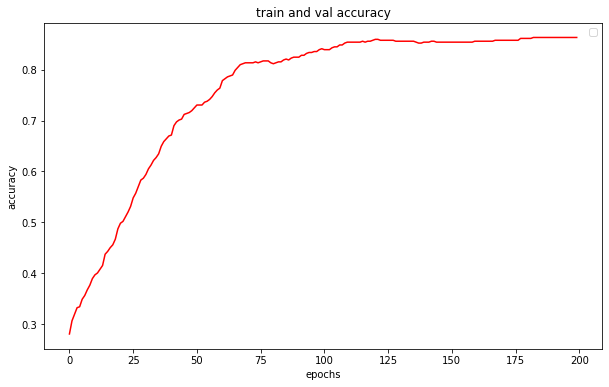

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(val_acc, 'r')
plt.title("train and val accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='best')

plt.show()
plt.savefig("accuracy.png")
plt.close()


# Loss

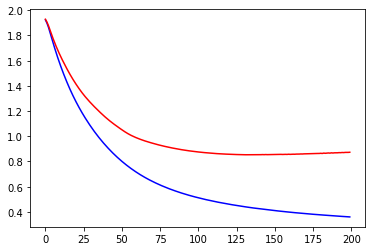

In [18]:
plt.plot(train_lost,'b')
plt.plot(val_lost,'r')